In [1]:
import numpy as np
import sklearn
import pandas as pd
from PIL import Image
import os
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.measure import block_reduce

In [2]:
data = {'gt':[], 'nt':[], 'mt':[], 'pt':[]}

def im_to_arr(dfl:list, path:str):
    filenames = os.listdir(path=path)
    filen = len(filenames)
    for i in range(filen):
        img = Image.open(path+'/'+filenames[i]).convert('L')
        dfl.append([np.asarray(img), img])

In [3]:
im_to_arr(data['gt'], "tumor_dataset/Training/glioma_tumor")
im_to_arr(data['nt'], "tumor_dataset/Training/no_tumor")
im_to_arr(data['mt'], "tumor_dataset/Training/meningioma_tumor")
im_to_arr(data['pt'], "tumor_dataset/Training/pituitary_tumor")

In [4]:
def imageshow(arr:np.ndarray):
    plt.figure(figsize=(5, 5))
    plt.imshow(arr, cmap='gray')
    plt.axis('off')
    plt.show()

In [24]:
def imgshow5x5(l:list, order=False) -> list:
    imgtable = [l[i] for i in np.random.choice(list(range(len(l))), size=25, replace=False)] \
        if not order else [l[i] for i in order]
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))

    for i in range(5):
        for j in range(5):
            axes[i, j].imshow(imgtable[i*5+j], cmap='gray')
            axes[i, j].axis('off')
            
    plt.show()
    return imgtable

이미지 비율이 512x512가 아닌 애들끼리 학습(512*512 & no_tumor인건 제거)   
이미지 비율이 512x512인 애들은 사진 찍은 각도에 대해 분류 후 지들끼리 하거나 레이블 추가

In [14]:
def delete_bg(imgarr:np.ndarray, img:Image) -> list:
    ''' return `True` if img is 512x512 for third value. '''
    margin = [[-1,-1],[-1,-1]]
    wh = img.size
    for i in range(2):
        max_col = imgarr.max(axis=i)
        arr = max_col >= 40; streak = [0,0]; ssp = [-1,-1]; flag = 0
        for j in range(wh[i]):
            if flag == 2: break
            if margin[i][0] == -1:
                if arr[j]:
                    streak[0] += 1
                    if ssp[0] == -1: ssp[0] = j
                    if streak[0] >= wh[i]//7:
                        margin[i][0] = ssp[0]; flag += 1
                else: streak[0] = 0; ssp[0] = -1
            if margin[i][1] == -1:
                if arr[-j-1]:
                    streak[1] += 1
                    if ssp[1] == -1: ssp[1] = wh[i]-j
                    if streak[1] >= wh[i]//7:
                        margin[i][1] = ssp[1]; flag += 1
                else: streak[1] = 0; ssp[1] = -1
        # margin[i][0] = np.argmax(max_col >= 40); margin[i][1] = wh[i] - np.argmax(np.flip(max_col) >= 40)
    timg = img.crop((margin[0][0],margin[1][0],margin[0][1],margin[1][1])).resize((512,512))
    timgarr = np.asarray(timg)
    
    return [timgarr, timg, wh[0] == 512 and wh[1] == 512]

In [7]:
for k in data.keys():
    for i in range(len(data[k])):
        data[k][i] = delete_bg(data[k][i][0], data[k][i][1])

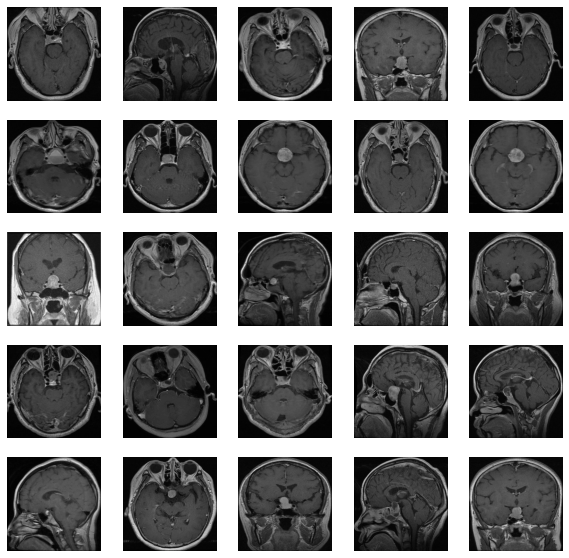

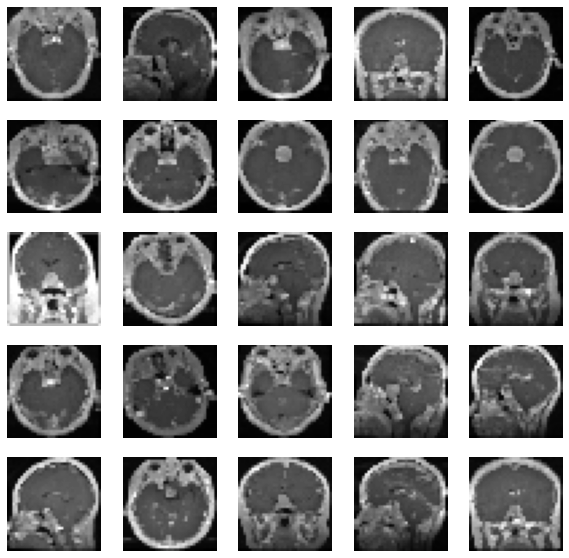

In [25]:
imgtable = imgshow5x5(list(map(lambda x: x[0], data['pt'])))
pooled = [block_reduce(np.asarray(imgtable[i]), (15, 15), np.max) for i in range(25)]
_ = imgshow5x5(pooled, order=list(range(25)))

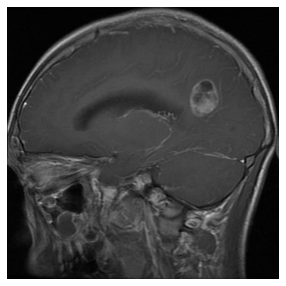

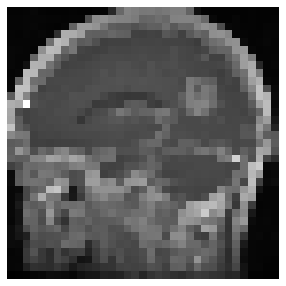

(35, 35)


In [11]:
imageshow(data['gt'][17][0])
pooled = block_reduce(data['gt'][17][0], (15, 15), np.max)
imageshow(pooled)
print(pooled.shape)